In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver13.csv")
df2 = pd.read_csv("data/26년FA_야수_ver2.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 전처리 함수 정의
def preprocess(df):
    df = df.copy()
    if '구분' in df.columns:
        df = df[~df['구분'].isin(['해외', 'FA 1년차'])]
    if 'FA등급' in df.columns:
        df = df[~df['FA등급'].isin(['해외', 'FA 1년차'])]
    if '플레이년도' in df.columns:
        df = df[df['플레이년도'] > 2015]

    drop_cols = ['선수명_수정', 'FA 계약 총액', '연봉', '잔류여부']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    df = df.groupby('선수명', as_index=False).mean(numeric_only=True)
    return df

df1_cleaned = preprocess(df1)
df2_cleaned = preprocess(df2)

C:\Users\Lee\AppData\Local\Temp\ipykernel_21816\3216511609.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')


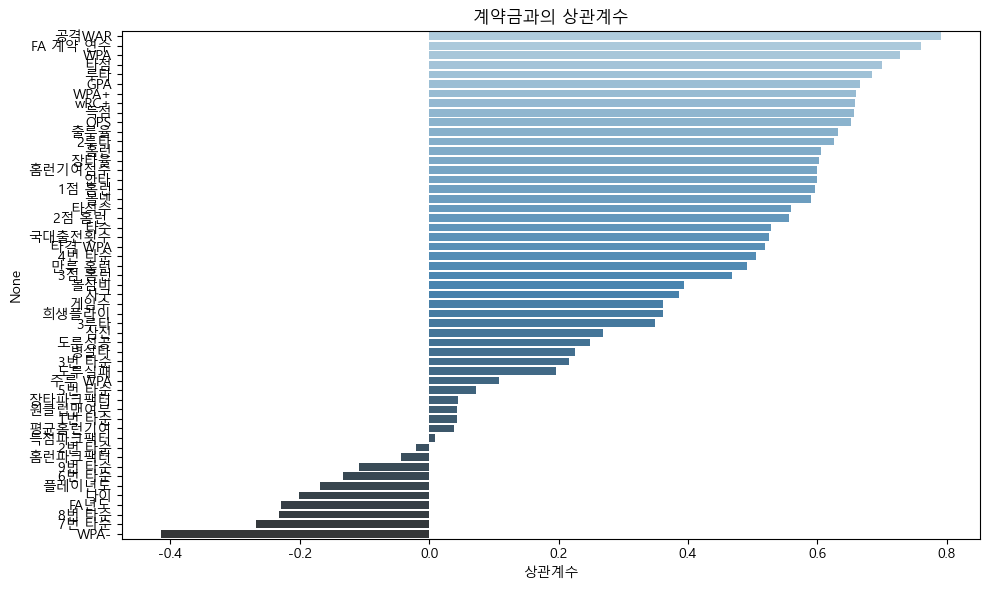

In [5]:
# 상관계수 및 가중치 계산
correlations = df1_cleaned.corr(numeric_only=True)['계약금'].drop('계약금').sort_values(ascending=False)
weights = correlations.abs() / correlations.abs().sum()
weight_df = pd.DataFrame({'컬럼명': weights.index, '가중치': weights.values})

# 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')
plt.title('계약금과의 상관계수')
plt.xlabel('상관계수')
plt.tight_layout()
plt.show()

In [6]:
# 예측에 사용할 피처 선택
predict_features = [f for f in weights.index if f in df1_cleaned.columns and f in df2_cleaned.columns]
X = df1_cleaned[predict_features]
y = df1_cleaned['계약금']
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[predict_features]
y = Xy['계약금']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df2_cleaned[predict_features]

In [7]:
# Optuna로 하이퍼파라미터 튜닝 (ElasticNet)
def objective(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0.01, 10.0, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.0, 1.0),
    }
    model = ElasticNet(**params, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return -score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2025-08-06 14:08:20,766] A new study created in memory with name: no-name-aa6edddf-a0e4-4c10-a589-64ee81f05144
C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.662e+10, tolerance: 1.222e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.458e+10, tolerance: 1.733e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterati

In [8]:
# 최적 모델 학습 및 검증
best_params = study.best_params
best_model = ElasticNet(**best_params, random_state=42)
best_model.fit(X_train, y_train)

val_pred = best_model.predict(X_val)

mse = mean_squared_error(y_val, val_pred)              
rmse = mean_squared_error(y_val, val_pred, squared=False)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

print(f"[모델 평가 지표]")
print(f" MSE : {mse:,.2f}")
print(f" RMSE: {rmse:,.2f}")
print(f" MAE : {mae:,.2f}")
print(f" R²  : {r2:.4f}")

print("[ElasticNet + Optuna] 최적 파라미터:")
print(best_params)

[모델 평가 지표]
 MSE : 20,180,775,116.05
 RMSE: 142,059.06
 MAE : 114,456.61
 R²  : 0.6052
[ElasticNet + Optuna] 최적 파라미터:
{'alpha': 2.0525915911607475, 'l1_ratio': 0.6810715895426436}


C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.290e+11, tolerance: 2.231e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
# 계약금 예측 및 반올림
df2_cleaned['계약금'] = best_model.predict(X_test).round(0).astype(int)

C:\Users\Lee\AppData\Local\Temp\ipykernel_21816\1716667916.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='컬럼명', x='중요도 (ElasticNet)', palette='coolwarm')


피처 중요도 (ElasticNet + Optuna):
       컬럼명  중요도 (ElasticNet)  상관계수 기반 가중치
19  국대출전횟수      16344.142607     0.024811
44   플레이년도      14149.384835     0.007939
30    도루성공       9748.834204     0.011745
5     WPA+       8224.836670     0.031188
25      사구       8174.076615     0.018232
0    공격WAR       8040.396777     0.037415
45      나이      -7850.594149     0.009510
15   1점 홈런       6559.603684     0.028206
34  주루 WPA       6380.307307     0.005100
2       타점       6156.518526     0.033115
13  홈런기여점수      -5329.096383     0.028368
27   희생플라이      -5137.071709     0.017067
1      WPA       5047.022569     0.034405
46    FA년도       4568.161704     0.010813
10     2루타      -3860.654899     0.029629
23   3점 홈런      -3302.023328     0.022117
20  타격 WPA      -2877.276988     0.024543
33    도루실패       2593.919190     0.009282
49    WPA-      -2014.028228     0.019624
37  원클럽맨여부      -1924.463297     0.002069
29      삼진      -1751.392211     0.012702
14      안타       1649.648150     0.028334
16  

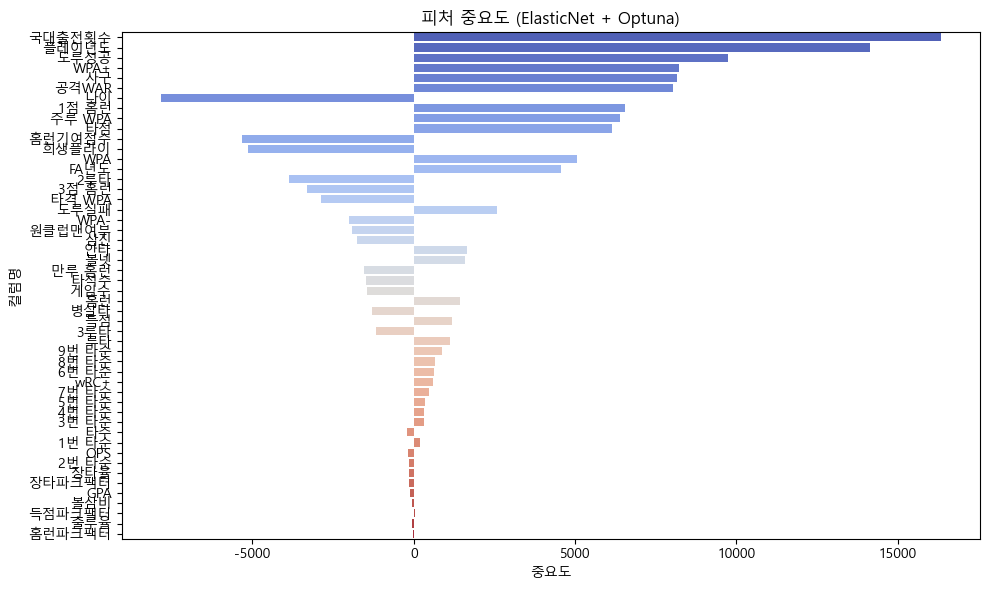

In [10]:
# 피처 중요도 분석
importance_df = pd.DataFrame({
    '컬럼명': predict_features,
    '중요도 (ElasticNet)': best_model.coef_,
    '상관계수 기반 가중치': [weights[f] for f in predict_features]
}).sort_values(by='중요도 (ElasticNet)', key=lambda x: abs(x), ascending=False)

print("피처 중요도 (ElasticNet + Optuna):")
print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, y='컬럼명', x='중요도 (ElasticNet)', palette='coolwarm')
plt.title('피처 중요도 (ElasticNet + Optuna)')
plt.xlabel('중요도')
plt.tight_layout()
plt.show()

In [11]:
# 11. 예측 결과 출력
print("예측 계약금 상위 선수 (ElasticNet + Optuna):")
print(df2_cleaned[['선수명', '계약금']].sort_values(by='선수명', ascending=True))

예측 계약금 상위 선수 (ElasticNet + Optuna):
    선수명     계약금
0   강민호  364243
1   강백호  249205
2   김재환   76659
3   박병호  280384
4   박승욱  127693
5   박찬호  381314
6   박해민  431093
7   손아섭  143669
8   이재원   47864
9   장성우  125735
10   정훈   11597
11  조수행  373422
12  최원준  355609
13  최형우  271120
14  황재균  132238
